**Assignment 2** **Convolution**

*Varshitha Guduru*

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"varshithaguduru","key":"0de9e49b039c369399099d7ab34b19e5"}'}

In [3]:
!mkdir ~/.kaggle/

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:21<00:00, 37.8MB/s]
100% 812M/812M [00:21<00:00, 39.4MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Since the model may overfit, we employ the regularization technique during the DATA PREPROCESSING stage. Here, every image is transformed into a tensor.

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Returning can be used to stop training early if the model is not progressing, or to store the model's weights at the end of each epoch. Callbacks can also be used to schedule changes in learning rate, log metrics, and visualize the model's performance.

In [13]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.keras",  # Change the file extension to .keras
        save_best_only=True,
        monitor='val_loss',  # Adjust the monitor as needed
        mode='min',          # Adjust the mode as needed
        verbose=1
    )
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5284 - loss: 0.8810
Epoch 1: val_loss improved from inf to 0.69258, saving model to convnet_from_scratch1.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.5283 - loss: 0.8790 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5143 - loss: 0.6932
Epoch 2: val_loss improved from 0.69258 to 0.69217, saving model to convnet_from_scratch1.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5145 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5300 - loss: 0.6895
Epoch 3: val_loss did not improve from 0.69217
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5300 - loss: 0.6894 - val_accuracy: 0.5000 - val_loss: 0.6968
Epoch 4/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5637 - loss: 0.6867
Epoch 4: val_loss improved from 0.69217 to 0.67953, saving model to convnet

It can be shown that accuracy rises with the number of epochs.

Accuracy=76.8% Val_acc=71.7% Test accuracy=75.5%

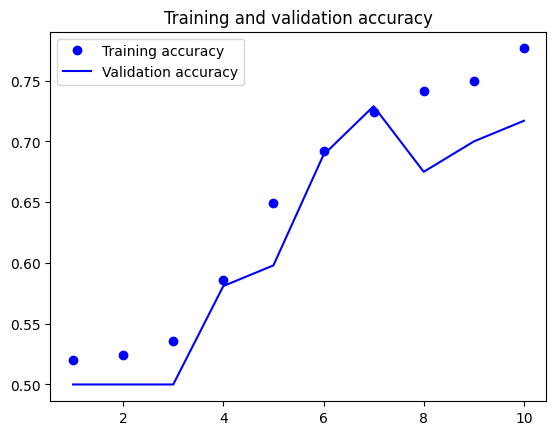

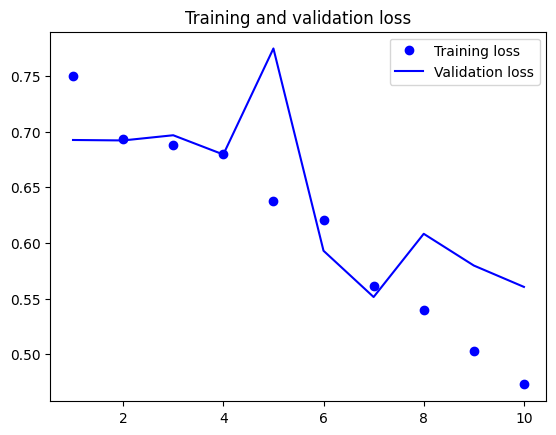

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [15]:
test_model = keras.models.load_model("convnet_from_scratch1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6903 - loss: 0.5933
Test accuracy: 0.705


test accruracy=70.5%

**Data Augmentation**

In order to increase the size of a training set, "data augmentation" creates new, modified versions of the original data. By doing this, overfitting is decreased and the model's ability to generalize is improved

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.5050 - loss: 0.7097 - val_accuracy: 0.5990 - val_loss: 0.6926
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5108 - loss: 0.6936 - val_accuracy: 0.5590 - val_loss: 0.6896
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5305 - loss: 0.6980 - val_accuracy: 0.6380 - val_loss: 0.6847
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5889 - loss: 0.6885 - val_accuracy: 0.6310 - val_loss: 0.6618
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5967 - loss: 0.6690 - val_accuracy: 0.6460 - val_loss: 0.6322
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.6071 - loss: 0.6636 - val_accuracy: 0.6260 - val_loss: 0.6558
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6302 - loss: 0.6579 - val_accuracy: 0.6690 - val_loss: 0.6164
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6604 - loss: 0.6224 - val_accuracy: 0.6420 - 

The model's performance was not enhanced by adding more data, but this may be verified by expanding the training sample and trying data augmentation on it.

Accuracy=70.5% Val accuracy=70.7% test accuracy=70.1%

In [19]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6784 - loss: 0.5919
Test accuracy: 0.701


test accuracy= 70.1%

**2) Expand the size of the training sample**

tried increasing the size of the training sample from 1000 to 1500

In [20]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [21]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [22]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.5343 - loss: 0.7346 - val_accuracy: 0.5000 - val_loss: 0.7245
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.5549 - loss: 0.6866 - val_accuracy: 0.6260 - val_loss: 0.6507
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6498 - loss: 0.6328 - val_accuracy: 0.6660 - val_loss: 0.6195
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.6858 - loss: 0.5901 - val_accuracy: 0.5890 - val_loss: 0.6532
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6898 - loss: 0.5691 - val_accuracy: 0.7080 - val_loss: 0.6036
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7487 - loss: 0.5250 - val_accuracy: 0.7140 - val_loss: 0.6407
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7489 - loss: 0.5122 - val_accuracy: 0.7030 - val_loss: 0.5873
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7734 - loss: 0.4615 - val_accuracy: 0.7330 

Accuracy=83.8% val accuracy=77.4 test accuracy=76.7%

In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7608 - loss: 0.5135
Test accuracy: 0.767


test accuracy=76.7%

**Using Data Augmentation**

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [29]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.4994 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6878
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5249 - loss: 0.6922 - val_accuracy: 0.5040 - val_loss: 0.6917
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.5245 - loss: 0.6945 - val_accuracy: 0.5210 - val_loss: 0.6924
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5198 - loss: 0.6905 - val_accuracy: 0.5180 - val_loss: 0.7005
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.5584 - loss: 0.6832 - val_accuracy: 0.5450 - val_loss: 0.6836
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5757 - loss: 0.6766 - val_accuracy: 0.6060 - val_loss: 0.6731
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6031 - loss: 0.6663 - val_accuracy: 0.6080 - val_loss: 0.6689
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.6288 - loss: 0.6490 - val_accuracy: 0.6250 - 

Accuracy=65.3% val accuracy= 66.3% test accuracy=68.5%

In [33]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6818 - loss: 0.6101
Test accuracy: 0.685


test accucary=68.5%

**3) Determine the optimal size of the training sample**

The sizes of the training, validation, and test sets were established at 1500, 1000, and 500, respectively.

In [34]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [35]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [36]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.5132 - loss: 0.7243 - val_accuracy: 0.5565 - val_loss: 0.6920
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.5352 - loss: 0.6993 - val_accuracy: 0.5595 - val_loss: 0.6843
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5714 - loss: 0.6840 - val_accuracy: 0.5625 - val_loss: 0.6751
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6268 - loss: 0.6577 - val_accuracy: 0.6030 - val_loss: 0.6462
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.6564 - loss: 0.6109 - val_accuracy: 0.7100 - val_loss: 0.5737
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7176 - loss: 0.5681 - val_accuracy: 0.7260 - val_loss: 0.5464
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7385 - loss: 0.5273 - val_accuracy: 0.7275 - val_loss: 0.5591
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.7655 - loss: 0.4966 - val_accuracy: 0

Accuracy=81.3 Val accuracy=73.7% test accuracy= 73.2%

In [40]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7429 - loss: 0.5448
Test accuracy: 0.732


test accuracy= 73.2%

**Using Data Augmentation**

In [41]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


In [42]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.5138 - loss: 0.6960 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5051 - loss: 0.6930 - val_accuracy: 0.5060 - val_loss: 0.6916
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.5060 - loss: 0.6930 - val_accuracy: 0.5930 - val_loss: 0.6870
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5574 - loss: 0.6884 - val_accuracy: 0.4990 - val_loss: 0.6938
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5222 - loss: 0.6914 - val_accuracy: 0.6125 - val_loss: 0.6699
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.5872 - loss: 0.6744 - val_accuracy: 0.6375 - val_loss: 0.6651
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5969 - loss: 0.6690 - val_accuracy: 0.6370 - val_loss: 0.6484
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.6398 - loss: 0.6518 - val_accuracy: 0.6365 

Accuracy=64.2% val accuracy= 66.9% test accuracy=67.4%

In [45]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6595 - loss: 0.6330
Test accuracy: 0.674


test accuracy=67.4%

**4) Making use of a trained network**

This pre-trained network has the architecture VGG16.


Extracting features: Creating the VGG16 convolutional basis

In [46]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Extraction of features and associated labels is known as feature extraction.

In [47]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

(3000, 5, 5, 512)

The process of creating and honing a highly connected classifier is known as feature extraction.

In [49]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8840 - loss: 27.7262 - val_accuracy: 0.9265 - val_loss: 12.5783
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9729 - loss: 4.1947 - val_accuracy: 0.9770 - val_loss: 3.1459
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9877 - loss: 1.5541 - val_accuracy: 0.9720 - val_loss: 5.7970
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9958 - loss: 0.4814 - val_accuracy: 0.9735 - val_loss: 5.2953
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.8198 - val_accuracy: 0.9705 - val_loss: 4.5475
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9915 - loss: 0.8778 - val_accuracy: 0.9750 - val_loss: 4.5427
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9977 - loss: 0.2196 - val_accuracy: 0.9785 - val_loss: 4.5383
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9976 - loss: 0.3015 - val_accuracy: 0.9765 - val_lo

Accuracy=100% val accuracy=96.9%

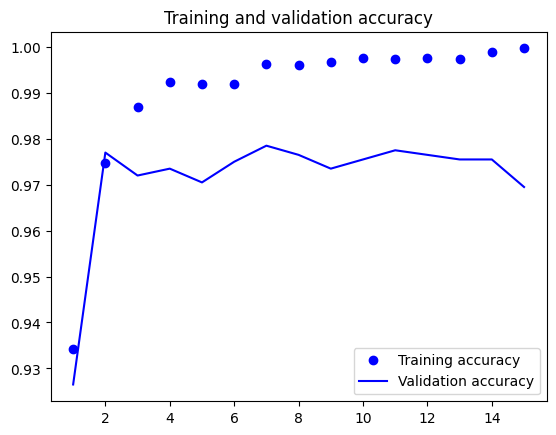

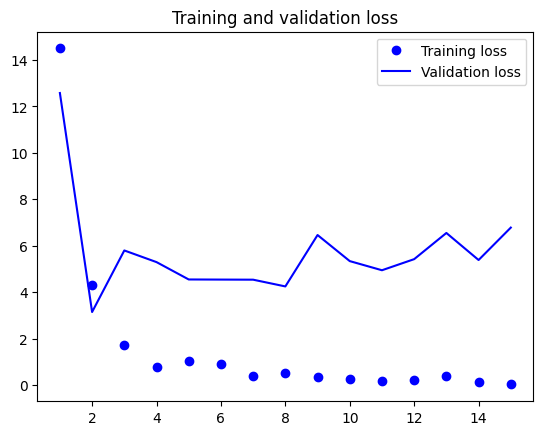

In [50]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [51]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


**Utilizing data augmentation for feature extraction**

In [52]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [53]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - accuracy: 0.8416 - loss: 27.9890 - val_accuracy: 0.9750 - val_loss: 3.5018
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - accuracy: 0.9506 - loss: 7.0282 - val_accuracy: 0.9780 - val_loss: 3.3481
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - accuracy: 0.9524 - loss: 6.2174 - val_accuracy: 0.9780 - val_loss: 3.0973
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.9547 - loss: 5.6535 - val_accuracy: 0.9655 - val_loss: 6.1592
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9622 - loss: 3.7970 - val_accuracy: 0.9700 - val_loss: 4.7663


Accuracy=96.2% val accuracy= 97.0% test accuracy= 97.0%

In [55]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentationPT2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9671 - loss: 6.0138
Test accuracy: 0.970


test accuracy= 97.0%

In [1]:
%%shell
jupyter nbconvert --to html //%%shell
jupyter nbconvert --to html //content//sample_data//Untitled2.ipynb

[NbConvertApp] WARNING | pattern '//%%shell' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute